# Práctica final
## Máster Universitario en Sistemas Inteligentes - Universidad de las Islas Baleares

### Alumno: Jover Mulet, Mateu
### Asignatura: Aprendizaje automático
### Año: 2020 - 2021

# 1. Presentación del problema.

El objetivo de este notebook es intentar una predicción de precios para alojamientos ofertados en la plataforma AirBnB. El conjunto de datos empleado proviene de la propia plataforma con la información de diversas categorías que ellos registran. Muchas de estas características vienen fijadas por el ofertante o _host_ con lo que algunas pueden venir algo distorsionadas o tener un formato no uniforme. Por otro lado, hay que saber que la plataforma ofrece todo tipo de alquileres, no solo turísticos y entre los turísticos los hay de precios muy variados dadas las carácteríticas de lo ofrecido.

El problema pretende limpiar y uniformizar los datos de los hospedajes que facilita el conjunto de datos. Los datos mejorados se emplearán para crear unos modelos de regresión lineal, (ya que la variable a predecir es numérica y contínua a priori). Como es habitual en el _workflow_ del _Machine Learning_ se empleará una fracción de los datos como validación del modelo creado.

Repositorio GitHub con lo necesario para ejecutar la práctica:  [mateujover/practicaAA_UIB_MUSI_2021](https://github.com/mateujover/practicaAA_UIB_MUSI_2021)

## 1.1. Preparación del entorno y primera observación de los datos:

### Librerías y carga de datos:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Librerías:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
# Datos:
file_path = "data/airbnb.csv"
df = pd.read_csv(file_path)
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11547,https://www.airbnb.com/rooms/11547,20200919153121,2020-09-21,My home at the beach,"Sun, joy, relax, quality, beach & peace.<br />...",NaN,https://a0.muscache.com/pictures/494126/8c151b...,42942,https://www.airbnb.com/users/show/42942,...,10.0,10.0,10.0,NaN,f,1,1,0,0,0.93
1,100831,https://www.airbnb.com/rooms/100831,20200919153121,2020-09-21,HOUSE IN MALLORCA - WiFi(ET-3045),<b>The space</b><br />House situated in a quie...,NaN,https://a0.muscache.com/pictures/675527/72b329...,529151,https://www.airbnb.com/users/show/529151,...,10.0,10.0,10.0,ETV-3045,t,1,1,0,0,1.47
2,105891,https://www.airbnb.com/rooms/105891,20200919153121,2020-09-20,VILLAGE HOUSE WITH POOL: IDEAL FOR FAMILIES,The house is a street on the outskirts of the ...,The village's population does not reach two th...,https://a0.muscache.com/pictures/1036816/f36ce...,549192,https://www.airbnb.com/users/show/549192,...,10.0,9.0,10.0,ETV/6127,t,2,2,0,0,0.14
3,106833,https://www.airbnb.com/rooms/106833,20200919153121,2020-09-20,Villa with a big pool in Mallorca,<b>The space</b><br />This is a restored old b...,NaN,https://a0.muscache.com/pictures/710218/98134c...,551974,https://www.airbnb.com/users/show/551974,...,10.0,9.0,9.0,ET/1961,f,1,1,0,0,0.09
4,130669,https://www.airbnb.com/rooms/130669,20200919153121,2020-09-20,Room great apartment,Located in a residential neighbourhood and 10m...,"Located in the center of the city, within minu...",https://a0.muscache.com/pictures/866653/58dc48...,643065,https://www.airbnb.com/users/show/643065,...,NaN,NaN,NaN,NaN,t,2,0,2,0,NaN


In [4]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

## ¿Qué _features_ escogemos inicialmente?
Aquellas que aporten información básica del hospedaje y su localización. Se incluyen las _features_ que especifican qué nivel de comodidad y aquello que incluye el contrato y además algunas relativas a la flexibilidad de la reserva:
1. Ubicación del alojamiento (latitud y longitud).
1. Tipo de alojamiento y tipo de habitación.
1. Número de huéspedes.
1. Habitaciones y camas.
1. Lista de comodidades por hospedaje (_amenities_)
1. Restricciones de reserva, máximo-mínimo de noches.
1. Disponibilidades para reservas de mes, dos meses, tres meses y anuales.
1. Precio (valor a predecir)

Las demás características son relativas datos sobre las interacciones o sobre el perfil del anunciante se excluyen ya que la mayoría no tienen un formato no apropiado ni información que se pueda considerar relevante.

In [5]:
basic_features = df.columns[29:46]
basic_features

Index(['latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights'],
      dtype='object')

In [6]:
basic_df = df[basic_features]
# basic_df[['latitude', 'longitude']].plot(kind='scatter', x='latitude', y='longitude')

# 2. Preparación del _dataframe_.
Observamos aquí las características del conjunto de datos para ver qué columnas necesitarán normalizarse, qué variables no son numéricas y debe adaptarse su tratamiento. Además deberán tratarse los valores NaN:

In [7]:
basic_features

Index(['latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights'],
      dtype='object')

## 2.1. Vista general del set de datos:

### Variables numéricas

In [8]:
numerical_features = basic_df.describe().columns
basic_df.describe()

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights
count,17608.000000,17608.000000,17608.000000,0.0,17333.000000,17511.000000,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000
mean,39.657597,2.994115,5.857962,NaN,2.952980,4.357147,4.340981,864.365459,4.531577,6.089334,840.952067,925.781520
std,0.165577,0.246129,2.727737,NaN,1.520433,2.561838,12.601256,451.521402,13.305965,15.672448,471.007202,409.085046
min,39.301970,2.346500,0.000000,NaN,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,39.543433,2.796892,4.000000,NaN,2.000000,3.000000,1.000000,700.000000,2.000000,3.000000,365.000000,1125.000000
50%,39.670285,3.047310,6.000000,NaN,3.000000,4.000000,4.000000,1125.000000,4.000000,5.000000,1125.000000,1125.000000
75%,39.797413,3.145215,8.000000,NaN,4.000000,6.000000,6.000000,1125.000000,5.000000,7.000000,1125.000000,1125.000000
max,39.930650,3.475520,16.000000,NaN,40.000000,50.000000,1124.000000,3500.000000,1124.000000,1124.000000,3500.000000,3500.000000


### Variables categóricas

In [9]:
no_numerical_features = list( set(numerical_features) ^ set(basic_features) )
basic_df[no_numerical_features].head()

,property_type,price,amenities,room_type,bathrooms_text
0,Entire apartment,$89.00,"[""Oven"", ""Wifi"", ""Coffee maker"", ""Dishes and s...",Entire home/apt,1 bath
1,Entire house,$175.00,"[""First aid kit"", ""Hair dryer"", ""Iron"", ""Washe...",Entire home/apt,3 baths
2,Entire townhouse,$140.00,"[""Smoke alarm"", ""Oven"", ""Wifi"", ""Garden or bac...",Entire home/apt,2 baths
3,Entire villa,$200.00,"[""Pool"", ""Free parking on premises"", ""Air cond...",Entire home/apt,1 bath
4,Private room in apartment,$110.00,"[""Pool"", ""Washer"", ""Air conditioning"", ""Kitche...",Private room,1 bath


### Resumen de _features_

1. Variables categóricas (o que aparecen como tal)
    
 - Precio: convertirlo a valor numérico.
 - Tipo de habitación: cuatro valores. Se usará un One Hot Encoding, son pocos valores para la variable. Se combinará con el _property\_type_
 - Tipo de propiedad: hasta 74 valores diferentes. Se valorarán la reducción de las categorías de forma manual para reducir el número de ellas y proceder con una codificación diferente y para combinarse con el tipo de habitación.
 - _Bathrooms text_: transformar a valores numéricos. Deben interpretarse algunos strings para pasarse a un valor numérico.
 - Comodidades (_amenities_): conjuntos de items para cada observación, de muy alta cardinalidad y sujetos a lo que los _host_ incluyan en la categoría _amenities_.
 
2. Variables numéricas:
 - Latitud-longitud: situación en el mapa.
 - _Accommodates_: número de personas máxima para el hospedaje.
 - Variables referentes a noches mínimas/máximas reservables: se redcirán tomándo el mínimo de los dos valores mínimos y el máximo de los dos valores máximos, por si hubiera disparidad. (Reaparece el problema de la información ofrecida por cada host de forma diferente y que puede tener incoherencias).
 - _Bathrooms_: número de baños en el hospedaje.
 - _Bedrooms_ y _beds_: habitaciones y camas en el hospedaje.

## 2.2. Tratamiento de los datos de formato no adecuado.

**1. Columna precio: información como string y no en formato numérico**

In [10]:
# Conversión precio a float
def obtain_price(column):
    for i in range(0, len(column)):
        price = column[i]
        price = price[1:]
        price = price.replace(',', '')
        column[i] = float(price)
        
obtain_price(basic_df['price'])

**2. Variable baños en dos columnas y de formanto no adecuado**

In [11]:
basic_df['bathrooms_text'].unique()

array(['1 bath', '3 baths', '2 baths', '1 private bath', '0 baths',
       '1.5 baths', '2 shared baths', '7 baths', '4.5 baths', '2.5 baths',
       '4 baths', '5 baths', 'Shared half-bath', '1.5 shared baths',
       '3.5 baths', '1 shared bath', '6 baths', '8 baths', nan,
       '6.5 baths', '9.5 baths', '5.5 baths', '7.5 baths',
       '12 shared baths', '4 shared baths', '8.5 baths', '0 shared baths',
       '2.5 shared baths', 'Half-bath', '12 baths', '11 baths',
       '13 baths', '9 baths', '3 shared baths', '3.5 shared baths',
       '12.5 baths', '32 baths', '19 baths', 'Private half-bath',
       '13 shared baths', '10 baths', '14 baths', '16 baths'],
      dtype=object)

In [12]:
def convert_bathrooms(df: pd.DataFrame, st = "bathrooms", col = "bathrooms_text"):
    for i in range(len(df)):
        s = df[col][i]
        if s == 'Shared half-bath':
            s = '0.5 '
        elif s == 'Half-bath':
            s = '0.5 '
        elif s == 'Private half-bath':
            s = '0.5 '
        if s is not np.nan:
            s = s[:s.index(' ')]
            df[st][i] = float(s)
    
convert_bathrooms(basic_df)

**3. Convertimos a One Hot la variable _room\_type_**
Puesto que si se ejecuta un *.unique()* sobre la columna sólo hay 4 diferentes valores, pues podemos codificar cómodamente como One Hot. Posteriormente, lo emplearemos para codificar otra

In [13]:
room_dummies = basic_df[['room_type']]
room_dummies = pd.get_dummies(room_dummies, prefix='is')
room_dummies.head()

,is_Entire home/apt,is_Hotel room,is_Private room,is_Shared room
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,0,0,1,0


### De las variables relativas al tipo de hospedaje se realizará un filtrado _ad-hoc_:
Apreciando que codificar en One Hot multiplicaría las columnas en demasía, buscamos un tratamiento basado en la observación del propio _data frame_. Siendo consciente que esta información procede de una lista que no conocemos lo acotada que puede ser, suponemos que están todas las posibilidades relevantes y, por ende, estamos modelando correctamente. 

En concreto, tomaríamos: apartment, house, townhouse, villa, gueshouse, loft, cottage, castle, condominium, boutique hotel, room, chalet, cabin, boat, Camper/RV, hostel, bed and breakfast, bungalow, ...

Dado que corresponde un poco con la definición que ofrece el *host*, eliminaremos esta valoración a priori se reincorporaría si el modelo de predicción no ofrece un error en la predicción aceptable.

### Adaptación del tipo de alojamiento:

In [14]:
# Adaptación de los tipos de propiedad:
prop_type = basic_df['property_type']
for i in range(len(prop_type)):
    prop_type[i] = prop_type[i].lower()
prop_type.unique()

array(['entire apartment', 'entire house', 'entire townhouse',
       'entire villa', 'private room in apartment', 'entire guesthouse',
       'private room in guest suite', 'private room in villa',
       'entire loft', 'entire cottage', 'castle', 'entire condominium',
       'room in boutique hotel', 'private room', 'private room in house',
       'entire chalet', 'entire cabin', 'private room in condominium',
       'entire guest suite', 'private room in boat',
       'private room in cottage', 'camper/rv', 'boat',
       'private room in townhouse', 'private room in hostel',
       'private room in bed and breakfast', 'entire serviced apartment',
       'private room in guesthouse', 'shared room in apartment',
       'farm stay', 'room in serviced apartment',
       'room in bed and breakfast', 'private room in chalet',
       'entire bungalow', 'room in hotel', 'island',
       'shared room in igloo', 'private room in farm stay',
       'shared room in bed and breakfast', 'entire 

### Resumimos las frases para las diferentes descripciones

Consideramos lógico que en el precio influyan de diferente forma si es privado/compartido, si es el hospedaje entero o solo una habitación (room/entire) o si qué tipo de construcción más típicas sería (home/apartment/hotel/hostel/resort) y si no es ninguno de ellos se guardará igual.

In [15]:
for i in range(len(prop_type)):
    new = []
    if 'entire' in prop_type[i]:
        new.append('entire')
    elif 'room' in prop_type[i]:
        new.append('room')
    else:
        new.append(None)
        
    if 'private' in prop_type[i]:
        new.append('private')
    elif 'shared' in prop_type[i]:
        new.append('shared')
    else:
        new.append(None)
        
    if 'house' in prop_type[i]:
        new.append('house')
    elif 'casa' in prop_type[i]:
        new.append('house')
    elif 'apartment' in prop_type[i]:
        new.append('apartment')
    elif 'hotel' in prop_type[i]:
        new.append('hotel')
    elif 'hostel' in prop_type[i]:
        new.append('hostel')
    elif 'resort' in prop_type[i]:
        new.append('resort')
    elif 'villa' in prop_type[i]:
        new.append('villa')
    else:
        new.append(None)
    
    if all(item == None for item in new):
        new.append(prop_type[i])
    else:
        new.append(None)
        
    prop_type[i] = new

basic_df['property_type'] = prop_type

Se completa el resumen de las descripciones con la información de la columna _room_type_.

In [16]:
for i in range(len(basic_df)): # que es la misma que room dummies
    l = basic_df['property_type'][i]
    if room_dummies['is_Entire home/apt'][i] == 1:
        l[0] = 'entire'
        l[2] = 'apartment'
        l[3] = None
    elif room_dummies['is_Hotel room'][i] == 1:
        l[0] = 'entire'
        l[1] = 'private'
        l[2] = 'hotel'
        l[3] = None
    elif room_dummies['is_Private room'][i] == 1:
        l[0] = 'room'
        l[1] = 'private'
    else:
        l[0] = 'room'
        l[1] = 'shared'
    basic_df['property_type'][i] = l
    
basic_df.head()

,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights
0,39.51888,2.48182,"[entire, None, apartment, None]",Entire home/apt,2,1.0,1 bath,1.0,1.0,"[""Oven"", ""Wifi"", ""Coffee maker"", ""Dishes and s...",89,5,60,5,5,60,60
1,39.76347,3.16255,"[entire, None, apartment, None]",Entire home/apt,8,3.0,3 baths,4.0,7.0,"[""First aid kit"", ""Hair dryer"", ""Iron"", ""Washe...",175,7,365,7,7,1125,1125
2,39.66044,3.07165,"[entire, None, apartment, None]",Entire home/apt,6,2.0,2 baths,3.0,4.0,"[""Smoke alarm"", ""Oven"", ""Wifi"", ""Garden or bac...",140,6,365,6,6,365,365
3,39.61600,3.30121,"[entire, None, apartment, None]",Entire home/apt,4,1.0,1 bath,2.0,4.0,"[""Pool"", ""Free parking on premises"", ""Air cond...",200,5,365,5,5,365,365
4,39.56478,2.60333,"[room, private, apartment, None]",Private room,2,1.0,1 bath,1.0,2.0,"[""Pool"", ""Washer"", ""Air conditioning"", ""Kitche...",110,2,365,2,2,365,365


- Tratamiento de las **variables _amenities_**: 
se revisa el contenido de las listas de strings que implica esta característica.

In [17]:
amenities = basic_df[['amenities']]
l_amnt = []
for i in range(len(amenities)):
    amnt = amenities['amenities'][i]
    amnt = amnt.replace('[', '')
    amnt = amnt.replace(' ', '')
    amnt = amnt.replace('"', '')
    amnt = amnt.replace(']', '')
    amnt = amnt.lower()
    amnt = amnt.split(',')
    l_amnt.extend(amnt)
    l_amnt = list(set(l_amnt)) # remove duplicates

len(l_amnt)

210

Observamos que en el conjunto de existen hasta 210 items diferentes. Las comodidades también dependen de la descripción que desee ofrecer el hospedador. Con lo que se valorará incluirlas en posibles mejoras del modelo si los datos incluidos no son suficientes y como un valor numérico igual a la cantidad de items para cada observación del data frame. Codificaciones como el el One Hot no son útiles para este caso, por ejemplo.

In [18]:
amenities = basic_df.pop('amenities')

## 2.3. Separamos en variables numéricas y no numericas para tratar los posibles NaN y otros valores.

In [19]:
for i in range(len(basic_df)):
    basic_df['minimum_nights'][i] = np.minimum(basic_df['minimum_nights'][i], basic_df['minimum_minimum_nights'][i])
    basic_df['maximum_nights'][i] = np.maximum(basic_df['maximum_nights'][i], basic_df['maximum_maximum_nights'][i])
    
basic_df.describe()

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights
count,17608.000000,17608.000000,17608.000000,17600.000000,17333.000000,17511.000000,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000
mean,39.657597,2.994115,5.857962,2.290028,2.952980,4.357147,4.071842,933.881474,4.531577,6.089334,840.952067,925.781520
std,0.165577,0.246129,2.727737,1.362623,1.520433,2.561838,12.552854,402.517515,13.305965,15.672448,471.007202,409.085046
min,39.301970,2.346500,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,39.543433,2.796892,4.000000,1.000000,2.000000,3.000000,1.000000,1125.000000,2.000000,3.000000,365.000000,1125.000000
50%,39.670285,3.047310,6.000000,2.000000,3.000000,4.000000,3.000000,1125.000000,4.000000,5.000000,1125.000000,1125.000000
75%,39.797413,3.145215,8.000000,3.000000,4.000000,6.000000,5.000000,1125.000000,5.000000,7.000000,1125.000000,1125.000000
max,39.930650,3.475520,16.000000,32.000000,40.000000,50.000000,1124.000000,3500.000000,1124.000000,1124.000000,3500.000000,3500.000000


In [20]:
basic_df = basic_df.drop(['bathrooms_text', 'room_type', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights'], axis = 1)

## 2.4. Separación del dataframe para normalizar datos:
Separación del dataframe en la parte a priori numérica para normalizarla y por otro lado se condificará de otra forma, tras el resumen, la infromación contenida en `property_type`.

In [21]:
basic_df.head()

,latitude,longitude,property_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights
0,39.51888,2.48182,"[entire, None, apartment, None]",2,1.0,1.0,1.0,89,5,60
1,39.76347,3.16255,"[entire, None, apartment, None]",8,3.0,4.0,7.0,175,7,1125
2,39.66044,3.07165,"[entire, None, apartment, None]",6,2.0,3.0,4.0,140,6,365
3,39.61600,3.30121,"[entire, None, apartment, None]",4,1.0,2.0,4.0,200,5,365
4,39.56478,2.60333,"[room, private, apartment, None]",2,1.0,1.0,2.0,110,2,365


Extraemos la variable `property_type` para codificar cada una de sus valores en una serie de datos numéricos enteros.

In [22]:
prop_type = basic_df.pop('property_type')
numericals = basic_df
numericals.head()

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights
0,39.51888,2.48182,2,1.0,1.0,1.0,89,5,60
1,39.76347,3.16255,8,3.0,4.0,7.0,175,7,1125
2,39.66044,3.07165,6,2.0,3.0,4.0,140,6,365
3,39.61600,3.30121,4,1.0,2.0,4.0,200,5,365
4,39.56478,2.60333,2,1.0,1.0,2.0,110,2,365


### 2.4.1. Property type: recodificación

Las diferentes columnas de _prop_type_ se codificarán de la siguiente froma.

1. Entire/room: +1/-1 y 0 en caso de None.
1. Private/shared: +1/-1 y 0 para None.
1. Villa/vouse/apartment/hostel/resort/hotel: +3/+2/+1/-1/-2/-3 y 0 para None.
1. La cuarta columna será 0 para None y 1 para cualquier otro valor.

In [23]:
_one = {'entire': +1, 'room': -1, None: 0}
_two = {'private': +1, 'shared': -1, None: 0}
_three = {'villa': +3, 'house': +2, 'apartment': +1, 'hostel': -1, 'resort': -2, 'hotel': -3, None: 0}

In [24]:
new_prop_type = []
for i in prop_type:
    integers = np.zeros(4)
    integers[0] = _one[i[0]]
    integers[1] = _two[i[1]]
    integers[2] = _three[i[2]]
    if i[3] == None:
        integers[3] = 0
    else:
        integers[3] = 1
    new_prop_type.append(integers)

In [25]:
prop_type = pd.DataFrame(np.array(new_prop_type), columns=['entire_room', 'private_shared', 'business', 'uncommon'])
prop_type.describe()

,entire_room,private_shared,business,uncommon
count,17608.000000,17608.000000,17608.000000,17608.0
mean,0.817356,0.102226,0.902715,0.0
std,0.576150,0.306496,0.672984,0.0
min,-1.000000,-1.000000,-3.000000,0.0
25%,1.000000,0.000000,1.000000,0.0
50%,1.000000,0.000000,1.000000,0.0
75%,1.000000,0.000000,1.000000,0.0
max,1.000000,1.000000,3.000000,0.0


### 2.4.2. Numerical data:

In [26]:
price = numericals.pop('price')
numericals.head() # Normalizaremos los datos sin atacar el precio

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights
0,39.51888,2.48182,2,1.0,1.0,1.0,5,60
1,39.76347,3.16255,8,3.0,4.0,7.0,7,1125
2,39.66044,3.07165,6,2.0,3.0,4.0,6,365
3,39.61600,3.30121,4,1.0,2.0,4.0,5,365
4,39.56478,2.60333,2,1.0,1.0,2.0,2,365


#### Tratamiento de valores NaN:
Con el imputer de Sklearn introduciremos la mediana (para ser menos sensibles a los outliers) como el valor para los datos que faltan en el data frame.

In [27]:
from sklearn.impute import SimpleImputer
numericals_names = numericals.columns
median_inputer = SimpleImputer(missing_values=np.nan, strategy='median')
numericals = median_inputer.fit_transform(numericals)
numericals = pd.DataFrame(numericals, columns = numericals_names)
no_scaled_numericals = numericals
numericals.describe()

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights
count,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000
mean,39.657597,2.994115,5.857962,2.289897,2.953714,4.355179,4.071842,933.881474
std,0.165577,0.246129,2.727737,1.362328,1.508524,2.554909,12.552854,402.517515
min,39.301970,2.346500,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,39.543433,2.796892,4.000000,1.000000,2.000000,3.000000,1.000000,1125.000000
50%,39.670285,3.047310,6.000000,2.000000,3.000000,4.000000,3.000000,1125.000000
75%,39.797413,3.145215,8.000000,3.000000,4.000000,6.000000,5.000000,1125.000000
max,39.930650,3.475520,16.000000,32.000000,40.000000,50.000000,1124.000000,3500.000000


#### Normalizaión:

Con escalados de los datos menos sensibles a la desviación que sufre la media por la presencia de _outliers_, favorecemos el escalado de los datos sin que afecte tanto al modelo que se generará. Otra posibilidad que ofrece Scikit-Learn es normalizar mediante el `RobustScaler` que se ofrece como una solución adecuada también para conjuntos de datos con bastantes _outliers_.

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numericals = scaler.fit_transform(numericals)
numericals = pd.DataFrame(numericals, columns = numericals_names)
numericals.describe()

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights
count,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000
mean,0.565672,0.573608,0.366123,0.071559,0.050095,0.087104,0.002735,0.266614
std,0.263373,0.218003,0.170484,0.042573,0.038680,0.051098,0.011178,0.115038
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.384079,0.398923,0.250000,0.031250,0.025641,0.060000,0.000000,0.321235
50%,0.585854,0.620724,0.375000,0.062500,0.051282,0.080000,0.001781,0.321235
75%,0.788068,0.707441,0.500000,0.093750,0.076923,0.120000,0.003562,0.321235
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2.4.3. Recombinamos los dataframes (numericals y prop_type)

In [29]:
adj_df = pd.concat([prop_type, numericals], axis = 1) # Después de normalizar dejamos el precio al final del dataframe
adj_df.describe()

,entire_room,private_shared,business,uncommon,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights
count,17608.000000,17608.000000,17608.000000,17608.0,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000
mean,0.817356,0.102226,0.902715,0.0,0.565672,0.573608,0.366123,0.071559,0.050095,0.087104,0.002735,0.266614
std,0.576150,0.306496,0.672984,0.0,0.263373,0.218003,0.170484,0.042573,0.038680,0.051098,0.011178,0.115038
min,-1.000000,-1.000000,-3.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.0,0.384079,0.398923,0.250000,0.031250,0.025641,0.060000,0.000000,0.321235
50%,1.000000,0.000000,1.000000,0.0,0.585854,0.620724,0.375000,0.062500,0.051282,0.080000,0.001781,0.321235
75%,1.000000,0.000000,1.000000,0.0,0.788068,0.707441,0.500000,0.093750,0.076923,0.120000,0.003562,0.321235
max,1.000000,1.000000,3.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


El data frame ha quedado con la columna objetivo a predecir al final y con todas las columnas consideradas relevantes para el primer modelo. Una de las propuestas para reducir la dimensionalidad es cambiar el tipo de coordenadas latitud-longitud a un ángulo y un radio al centro de la isla, incluso solo emplear el radio a modo de cercanía al mar.

**Todas las columnas tienen el mismos número de observaciones sin nulos y los datos normalizados y en un formato numérico.**

Dado que la columna `uncommon` queda completa de ceros, se elimina ya que de la codificación que se ha empleado no se saca ningún valor totalmente atípico.

In [30]:
adj_df.pop('uncommon')

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
17603    0.0
17604    0.0
17605    0.0
17606    0.0
17607    0.0
Name: uncommon, Length: 17608, dtype: float64

## 2.5. Colinealidad de los datos: Principal Component Analysis
Mediante un método de reducción de dimensionalidad como es PCA, se puede observar qué características del dataframe ajustado (`adj_df`) tras el tratamiento previo de los datos tienen una mayor explicabilidad de la variable `price` a estimar.

In [31]:
from sklearn.decomposition import PCA

In [32]:
pca = PCA(n_components = 2)
pca_data = pca.fit_transform(adj_df);

Reduciendo el espacio de variables a dos podemos ver como quedan las dos componentes principales:

In [33]:
pca_data_df = pd.DataFrame(pca_data, columns=['first_comp', 'second_comp'])
pca_data_df = pd.concat([pca_data_df, price], axis = 1)

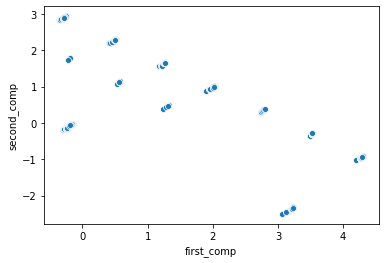

In [34]:
sns.scatterplot(data=pca_data_df, x='first_comp', y='second_comp')

## 2.6. Gráficas cruzadas

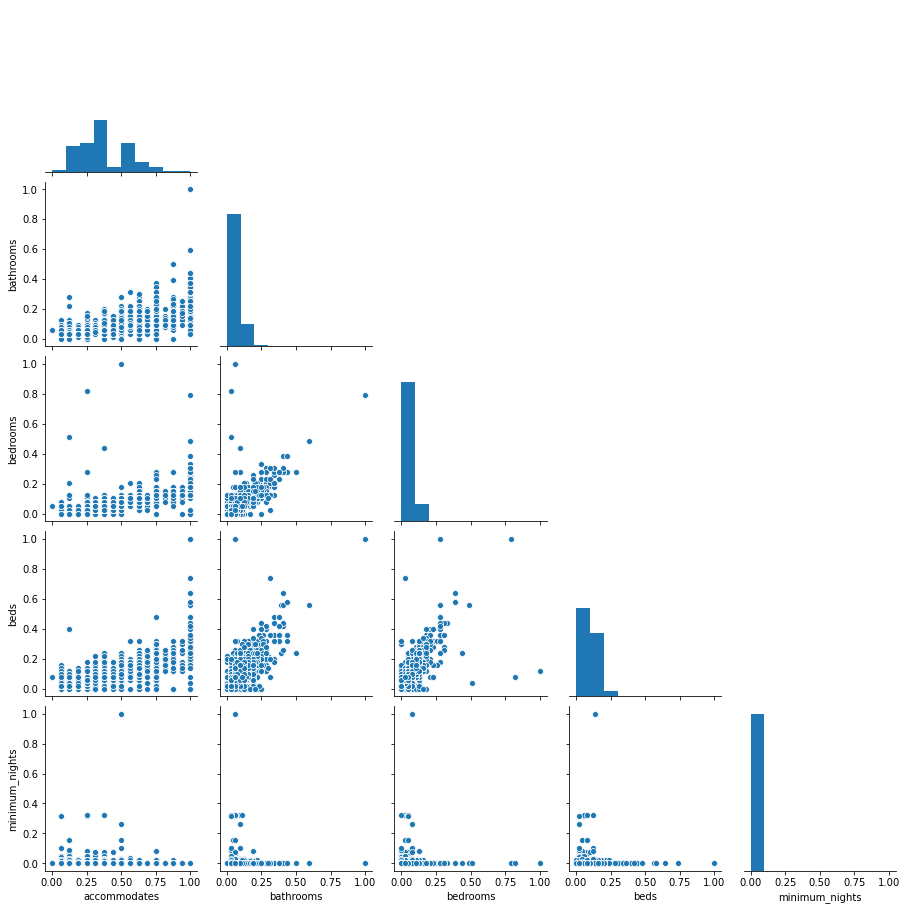

In [35]:
plot_df = adj_df[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights']]
sns.pairplot(data=plot_df, corner=True, diag_kind="hist")
del plot_df

#### Comentario acerca del _pairplot_

No se puede graficar destacando el precio, aún así puede verse la colinealidad de algunas de las variables a priori. Las más relacionadas entre sí son habitaciones (_bedrooms_), baños (_bathrooms_) y camas (_beds_).

Por otro lado, con las otras variables no se observa una relación muy evidente. Destaca la existencia de algunos puntos atípicos que hacen las visualizaciones algo más complicadas.

##  2.7. Algunas gráficas para observar posibles relaciones con el precio.

In [36]:
cols = adj_df.columns
cols = cols.drop(['bathrooms', 'bedrooms'])

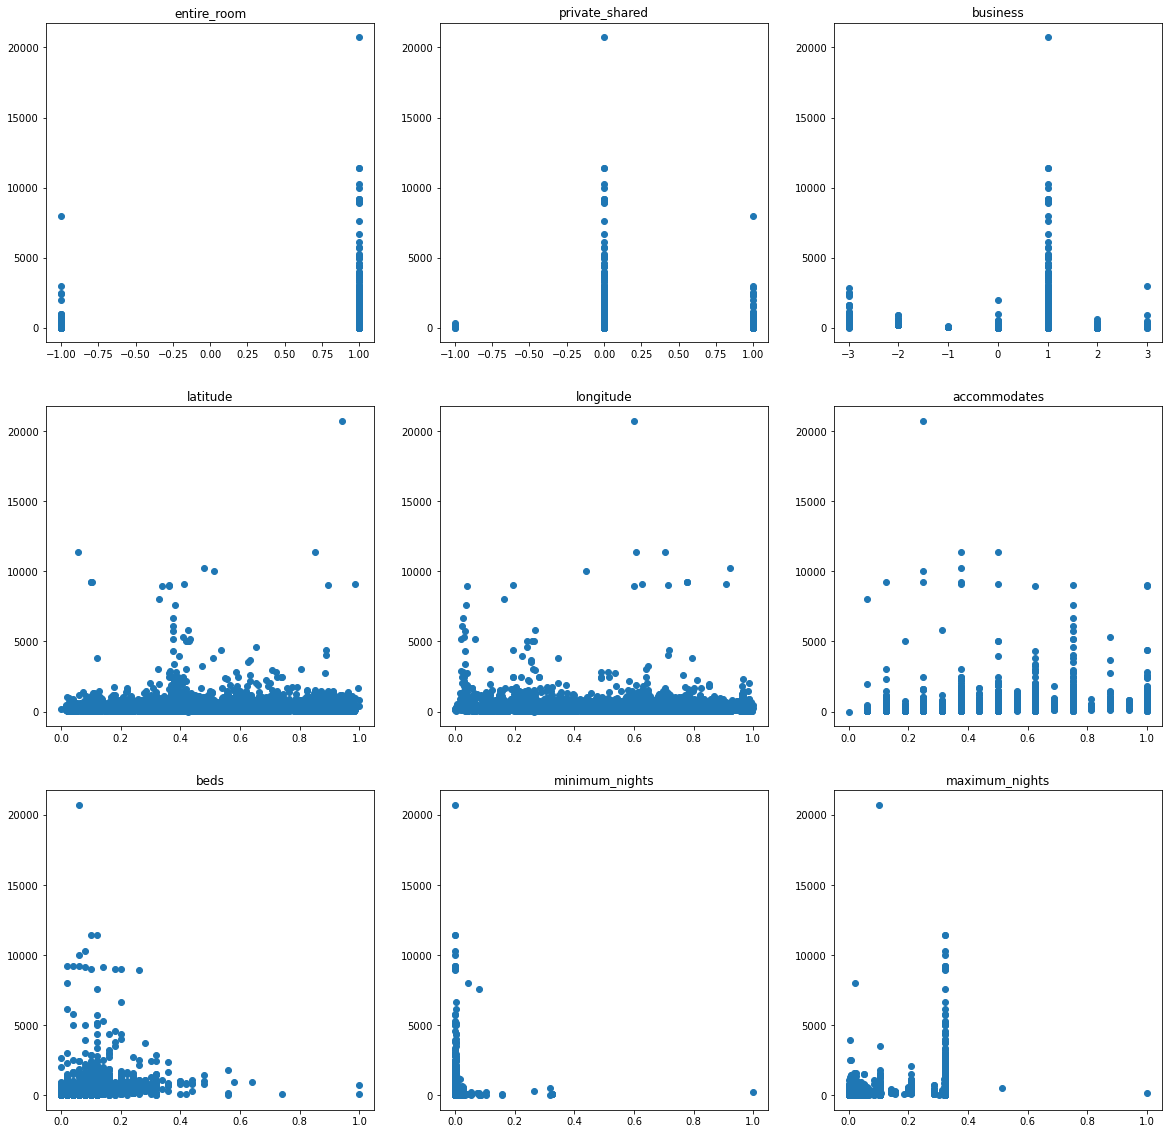

In [37]:
fig, axs = plt.subplots(3,3, figsize=(20,20))
y = np.array(price)
for i in range(3):
    for j in range(3):
        x = np.array(adj_df[ cols[i*3 + j] ])
        axs[i,j].scatter(x, y)
        axs[i,j].set_title(cols[3*i + j])

# 3. Selección de métricas y modelos.
Dado que la variable a predecir es un valor contínuo lo podemos relacionar de manera intuitiva a modelos de predicción o estimación de regresión. Para ello emplearemos un modelo de base sencillo para marcar una referencia. Este será una regresión lineal sobre el conjunto de datos de `basic_df`, que es el conjunto de datos original con los filtros y los arreglos previos a la reducción de dimensionalidad. Se esperaría que este fuera algo más ruidoso con lo que el _score_ de la métrica será peor. Se plantean mejoras del modelo como el uso de las componentes de la PCA con otra regresión lienal.

Para evaluar el modelo en cada caso se establecerá una evaluación mediante una **validación cuzada** sobre una métrica.
- Métrica escogida: **Mean Absolute Error (MAE)**.

Esta métrica aparece referenciada como más robusta ante las diferencias entre valores que provocan los valores atípicos ya que no se eleva al cuadrado. Se podría emplear también el _scorer_ RMSE (Root-Mean-Squared Error).

## 3.1. División entre datos de entrenamiento y de test:
De forma algo arbitraria se elige un tamaño razonable de datos de test (20%) con el que realizar las evaluaciones finales de los modelos.

In [38]:
from sklearn.model_selection import train_test_split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(adj_df, price, test_size=test_size, random_state=42)

Realizamos la misma operación sobre los datos transformados por el PCA:

In [39]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_data_df[['first_comp', 'second_comp']], pca_data_df[['price']], test_size=test_size, random_state=42)

## 3.2. _Scorer_ MAE:

In [40]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error as MAE
    
mae_scorer = make_scorer(MAE, greater_is_better=False)

# 4. Definición de los diferentes modelos.

In [41]:
# Importamos los modelos de scikit-learn
from sklearn.linear_model import LinearRegression

### 4.1. Modelo base:
Definimos aquí la regresión lineal que sirve de base para evaluar los diferentes modelos más sofisticados para dar dotar la resolución del problema de un _common ground_ y poder comparar con mejor perspectiva sobre una aproximación más básica.

In [42]:
base_model = LinearRegression()
base_model.fit(X_train, y_train)

LinearRegression()

### 4.2. Regresión lineal sobre PCA:

In [43]:
pca_linear_reg = LinearRegression()
pca_linear_reg.fit(X_train_pca, y_train_pca)

LinearRegression()

# 5. Validación y test de los modelos.

### 5.1. Validación cruzada sobre los datos de entrenamiento:

In [44]:
from sklearn.model_selection import cross_val_score
scores_base = -cross_val_score(estimator=base_model, X=X_train, y=y_train, cv=5, scoring=mae_scorer)

print(f"Media del error absoluto medio (base, train): {scores_base.mean()} +- {scores_base.std()}")

Media del error absoluto medio (base, train): 113.39722442919314 +- 3.222029703531161


---
> #### Media del error absoluto medio (base, train): 113.3 +- 3.2
---

In [45]:
scores_pca = -cross_val_score(estimator=pca_linear_reg, X=X_train_pca, y=y_train_pca, cv=5, scoring=mae_scorer)
print(f"Media del error absoluto medio (PCA, train): {scores_pca.mean()} +- {scores_pca.std()}")

Media del error absoluto medio (PCA, train): 142.0717491894576 +- 4.932458512912889


---
> #### Media del error absoluto medio (PCA, train): 141.9 +- 4.9
---

### 5.2. Evaluación sobre los datos de test:

In [46]:
mae_base = MAE(y_test, base_model.predict(X_test))
mae_pca =  MAE(y_test_pca, pca_linear_reg.predict(X_test_pca))
print(f"Error absoluto medio (base, test): {mae_base} \nError absoluto medio (PCA, test): {mae_pca}")

Error absoluto medio (base, test): 117.53075986123119 
Error absoluto medio (PCA, test): 146.3179114183328


### 5.3. Primer comentario sobre el modelo:
---
> #### El arreglo de los datos mediante la PCA no tiene ningún efecto positivo, provoca un aumento de la influencia del ruido y con ello producir una estimación de menor calidad.
---

# 6. Mejoras del modelo.
**OUTLIERS**:
Si se representan los datos del dataframe `adj_df`, con todas las características no observaríamos ninguna tendencia clara
Buscamos el centro de la isla, empleando los valores medios de cada columna del data frame. Luego calculamos la distancia euclídea, que no es físicamente exacta, pero en el rango de valores que empleamos el error no es relevante.

## 6.1. Eliminamos los puntos outliers, así reducimos el ruido del dataset.
¿En qué _features_ se observaban la mayoría de outliers?

Eliminaremos aquellos que se encuentren 2 desviaciones típicas por encima de los valores medios de las _features_:
- Accommodates
- Bathrooms
- Bedrooms
- Beds
- Minimum nights
- Maximum nights

Las otras características son o derivadas de categorías no numéricas y por tanto no tienen la misma naturaleza con lo que no se descartan observaciones de esta forma, o pueden ser las variables de longitud y latitud con las que se sitúa el habitaje.

In [47]:
acc_mean = adj_df['accommodates'].mean()
acc_std = adj_df['accommodates'].std()
acc_mask = adj_df['accommodates'] < (acc_mean + 2*acc_std)

bath_mean = adj_df['bathrooms'].mean()
bath_std = adj_df['bathrooms'].std()
bath_mask = adj_df['bathrooms'] < (bath_mean + 2*bath_std)

bedr_mean = adj_df['bedrooms'].mean()
bedr_std = adj_df['bedrooms'].std()
bedr_mask = adj_df['bedrooms'] < (bedr_mean + 2*bedr_std)

beds_mean = adj_df['beds'].mean()
beds_std = adj_df['beds'].std()
beds_mask = adj_df['beds'] < (beds_mean + 2*beds_std)

max_mean = adj_df['maximum_nights'].mean()
max_std = adj_df['maximum_nights'].std()
max_mask = adj_df['maximum_nights'] < (max_mean + 2*max_std)

min_mean = adj_df['minimum_nights'].mean()
min_std = adj_df['minimum_nights'].std()
min_mask = adj_df['minimum_nights'] < (min_mean + 2*min_std)

price_mean = price.mean()
price_std = price.std()
price_mask = price < (price_mean + 2*price_std)

mask = acc_mask & bath_mask & bedr_mask & beds_mask & min_mask & max_mask & price_mask
sum(mask)

16106

Observamos que el número total de observaciones pasará a ser 16106 observaciones en lugar de las más de 17000 originales.

## 6.2. Reescalamos los datos sobre la fracción resultante del data frames.

In [48]:
prop_type = prop_type[mask]
prop_type.pop('uncommon')
numericals = no_scaled_numericals[mask]
price = price[mask]

Nuevo reescalado de las variables numéricas:

In [49]:
numericals = scaler.fit_transform(numericals)
numericals = pd.DataFrame(numericals, columns = numericals_names)
numericals.describe()

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights
count,16106.000000,16106.000000,16106.000000,16106.000000,16106.000000,16106.000000,16106.000000,16106.000000
mean,0.570184,0.578629,0.493543,0.413523,0.430771,0.442851,0.088838,0.829372
std,0.265309,0.215600,0.202579,0.197371,0.287487,0.218657,0.088290,0.358764
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.391447,0.434596,0.363636,0.200000,0.250000,0.333333,0.000000,1.000000
50%,0.600345,0.624085,0.545455,0.400000,0.500000,0.444444,0.071429,1.000000
75%,0.796204,0.708785,0.636364,0.600000,0.750000,0.555556,0.142857,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
adj_df = pd.concat([prop_type, numericals, price], axis = 1)
adj_df.describe()

,entire_room,private_shared,business,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights
count,16106.000000,16106.000000,16106.000000,16106.000000,16106.000000,16106.000000,16106.000000,16106.000000,16106.000000,16106.000000,16106.000000
mean,0.807774,0.107538,0.898485,0.570184,0.578629,0.493543,0.413523,0.430771,0.442851,0.088838,0.829372
std,0.589511,0.313194,0.687089,0.265309,0.215600,0.202579,0.197371,0.287487,0.218657,0.088290,0.358764
min,-1.000000,-1.000000,-3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.391447,0.434596,0.363636,0.200000,0.250000,0.333333,0.000000,1.000000
50%,1.000000,0.000000,1.000000,0.600345,0.624085,0.545455,0.400000,0.500000,0.444444,0.071429,1.000000
75%,1.000000,0.000000,1.000000,0.796204,0.708785,0.636364,0.600000,0.750000,0.555556,0.142857,1.000000
max,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
adj_df = adj_df.dropna()
price = adj_df.pop('price')

## Visualizamos de nuevo igual que en 2.7.

In [52]:
cols = adj_df.columns
cols = cols.drop(['bathrooms', 'bedrooms'])

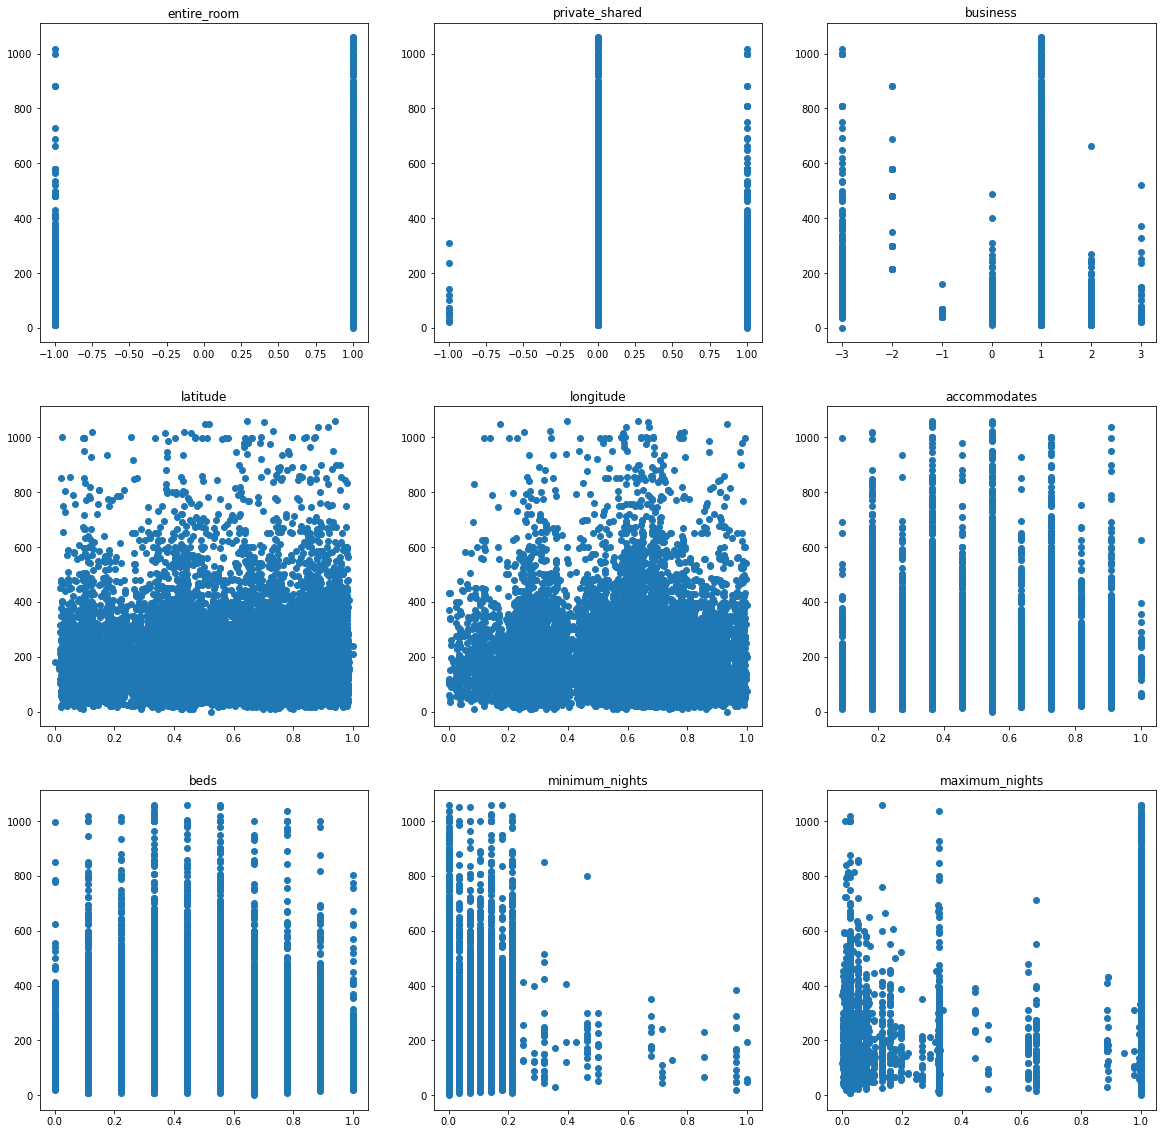

In [53]:
fig, axs = plt.subplots(3,3, figsize=(20,20))
y = np.array(price)
for i in range(3):
    for j in range(3):
        x = np.array(adj_df[ cols[i*3 + j] ])
        axs[i,j].scatter(x, y)
        axs[i,j].set_title(cols[3*i + j])

### Realizamos un PCA de nuevo:

In [54]:
pca_2 = PCA(n_components = 2)
pca_data = pca_2.fit_transform(adj_df);

In [55]:
pca_data_df = pd.DataFrame(pca_data, columns=['first_comp', 'second_comp'])
pca_data_df = pd.concat([pca_data_df, price], axis = 1)
pca_data_df = pca_data_df.dropna()

## 6.3. Renovamos los modelos:

### Nuevo split train-test:

In [56]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(adj_df, price, test_size=test_size, random_state=42)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_data_df[['first_comp', 'second_comp']], pca_data_df[['price']], test_size=test_size, random_state=42)

### "Refit" a los modelos:

In [57]:
base_model.fit(X_train, y_train)
pca_linear_reg.fit(X_train_pca, y_train_pca)

LinearRegression()

In [58]:
scores_base = -cross_val_score(estimator=base_model, X=X_train, y=y_train, cv=5, scoring=mae_scorer)

print(f"Media del error absoluto medio (base, train): {scores_base.mean()} +- {scores_base.std()}")

Media del error absoluto medio (base, train): 93.39510293807881 +- 2.0822789345528747


In [59]:
scores_pca = -cross_val_score(estimator=pca_linear_reg, X=X_train_pca, y=y_train_pca, cv=5, scoring=mae_scorer)
print(f"Media del error absoluto medio (PCA, train): {scores_pca.mean()} +- {scores_pca.std()}")

Media del error absoluto medio (PCA, train): 98.85963482592062 +- 2.3081591487675577


In [60]:
mae_base = MAE(y_test, base_model.predict(X_test))
mae_pca =  MAE(y_test_pca, pca_linear_reg.predict(X_test_pca))
print(f"Error absoluto medio (base, test): {mae_base} \nError absoluto medio (PCA, test): {mae_pca}")

Error absoluto medio (base, test): 93.29702845940336 
Error absoluto medio (PCA, test): 96.39523840769779


## 6.4. Comentario a las modificaciones.

---
> #### El arreglo de los datos eliminando outliers mejora la respuesta ligeramente del modelo que emplea los datos con las dimensiones reducidas. La estimación no acaba de modelar bien la posible tendencia en el data frame.
---

# 7. Conclusiones de la práctica.

#### Sobre el conjunto de datos:

1. El tratamiento de los datos es fundamental:
    Los dataframes reales no ofrecen una estructura ordenada o columnas exentas de valores atípicos. Además, los _dataframes_ en crudo no tienen filtradas las características no relevantes o poco útiles.

2. Eliminar outliers favorece la predicción del modelo en tanto que una regresión lineal es poco flexible para modelar la varianza en los datos.

3. El conjunto de datos que se ha empleado tiene un alto número de muestras de muy alta varanza entre sí, aunque la variable _target_ no sea clasificable si no se le crearan unas categorías o etiquetas en función de su precio.

4. Los valores del precio, y más teniendo en cuenta que son alquileres son bastante variables por diversas razones. En primer lugar, la diferencia entre alquiler turístico, alquileres de lujo y alquileres para viviendas de familias/trabajadores/estudiantes. Luego las diferencias entre aquellos turísticos que con una baja calidad de la vivienda piden un precio muy alto, enfocado al turismo estacional, en contraste con grandes equipamientos en casas para turistas no tan estacionales. El mercado del alquiler de la vivienda de alquiler es voluble y aún más variable en el sector al que se dedica AirBnB.

#### Rendimiento del modelo:

1. Los _scores_ obtenidos son algo pobres para lo que sería deseable para poner en un modelo a nivel de producción. Seguramente sería un indicador para descartar la propuesta.